# IPL Fantasy Points Prediction - Complete Analysis with Real Training

**Project**: Dream11 Fantasy Cricket Points Prediction  
**Dataset**: 1,149 IPL matches (2008-2025), 25,697 player-match records  
**Goal**: Predict fantasy points for IPL players to assist in Dream11 team selection

---

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Phase 1: Initial Models](#phase1)
4. [Phase 2: Advanced Features & Tuning](#phase2)
5. [Phase 3: Classification Approach](#phase3)
6. [Why Models Failed](#why-failed)
7. [Recommended Solution](#solution)
8. [Conclusions](#conclusions)

---
## 1. Setup & Data Loading <a id='setup'></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Try importing advanced libraries
try:
    import xgboost as xgb
    from xgboost import XGBRegressor, XGBClassifier
    print("✓ XGBoost available")
except:
    print("✗ XGBoost not available - install with: pip install xgboost")
    xgb = None

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor, LGBMClassifier
    print("✓ LightGBM available")
except:
    print("✗ LightGBM not available - install with: pip install lightgbm")
    lgb = None

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\nLibraries imported successfully!")

✗ XGBoost not available - install with: pip install xgboost
✗ LightGBM not available - install with: pip install lightgbm

Libraries imported successfully!


In [2]:
# Load pre-processed data
player_matches = pd.read_csv('../data/player_match_base.csv')
player_matches['match_date'] = pd.to_datetime(player_matches['match_date'])

roles_by_season = pd.read_csv('../data/player_roles_by_season.csv')
roles_global = pd.read_csv('../data/player_roles_global.csv')

print(f"Dataset loaded successfully!")
print(f"Total player-match records: {len(player_matches):,}")
print(f"Unique players: {player_matches['player_id'].nunique()}")
print(f"Date range: {player_matches['match_date'].min().date()} to {player_matches['match_date'].max().date()}")

Dataset loaded successfully!
Total player-match records: 25,697
Unique players: 765
Date range: 2008-05-03 to 2025-06-03


In [3]:
# Quick peek at the data
player_matches.head(10)

,match_date,player_id,player_name,team,opponent,venue,season,fantasy_points,runs,balls_faced,...,duck,wickets,balls_bowled,legal_balls_bowled,runs_conceded,maidens,lbw_bowled,catches,stumpings,runouts
0,2008-05-03,508a1ea7,SE Marsh,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,47,40,32,...,False,0,0,0,0,0,0,0,0,0
1,2008-05-03,d18f9182,DPMD Jayawardene,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,12,10,6,...,False,0,0,0,0,0,0,0,0,0
2,2008-05-03,a1f1829d,K Goel,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,7,6,7,...,False,0,0,0,0,0,0,0,0,0
3,2008-05-03,5fa06777,IK Pathan,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,106,24,26,...,False,2,25,24,18,0,2,1,0,0
4,2008-05-03,98ae73b1,PP Chawla,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,26,21,7,...,False,0,6,6,16,0,0,0,0,0
5,2008-05-03,6b8eb6e5,S Sreesanth,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,54,0,0,...,False,2,25,24,25,0,0,0,0,0
6,2008-05-03,034b4b7d,VRV Singh,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,35,0,0,...,False,1,24,24,31,0,1,0,0,0
7,2008-05-03,890de8cb,Gagandeep Singh,Kings XI Punjab,Kolkata Knight Riders,"Punjab Cricket Association Stadium, Mohali",2007/08,23,0,0,...,False,1,24,24,43,0,0,0,0,0
8,2008-05-03,9ab63e7b,Mohammad Hafeez,Kolkata Knight Riders,Kings XI Punjab,"Punjab Cricket Association Stadium, Mohali",2007/08,41,13,12,...,False,1,18,18,28,0,0,0,0,0
9,2008-05-03,7050a1e7,DB Das,Kolkata Knight Riders,Kings XI Punjab,"Punjab Cricket Association Stadium, Mohali",2007/08,12,5,8,...,False,0,0,0,0,0,0,0,0,1


---
## 2. Exploratory Data Analysis <a id='eda'></a>

Let's understand the distribution and patterns in fantasy points.

### 2.1 Fantasy Points Distribution

In [4]:
# Basic statistics
fp_stats = player_matches['fantasy_points'].describe()
print("Fantasy Points Statistics:")
print("="*50)
print(fp_stats)
print("\n" + "="*50)
print(f"Coefficient of Variation: {fp_stats['std'] / fp_stats['mean'] * 100:.1f}%")
print("\n⚠️ NOTE: Std Dev is 94% of mean - extremely high variance!")

Fantasy Points Statistics:
count    25697.000000
mean        33.870997
std         31.802798
min         -4.000000
25%          8.000000
50%         27.000000
75%         52.000000
max        286.000000
Name: fantasy_points, dtype: float64

Coefficient of Variation: 93.9%

⚠️ NOTE: Std Dev is 94% of mean - extremely high variance!


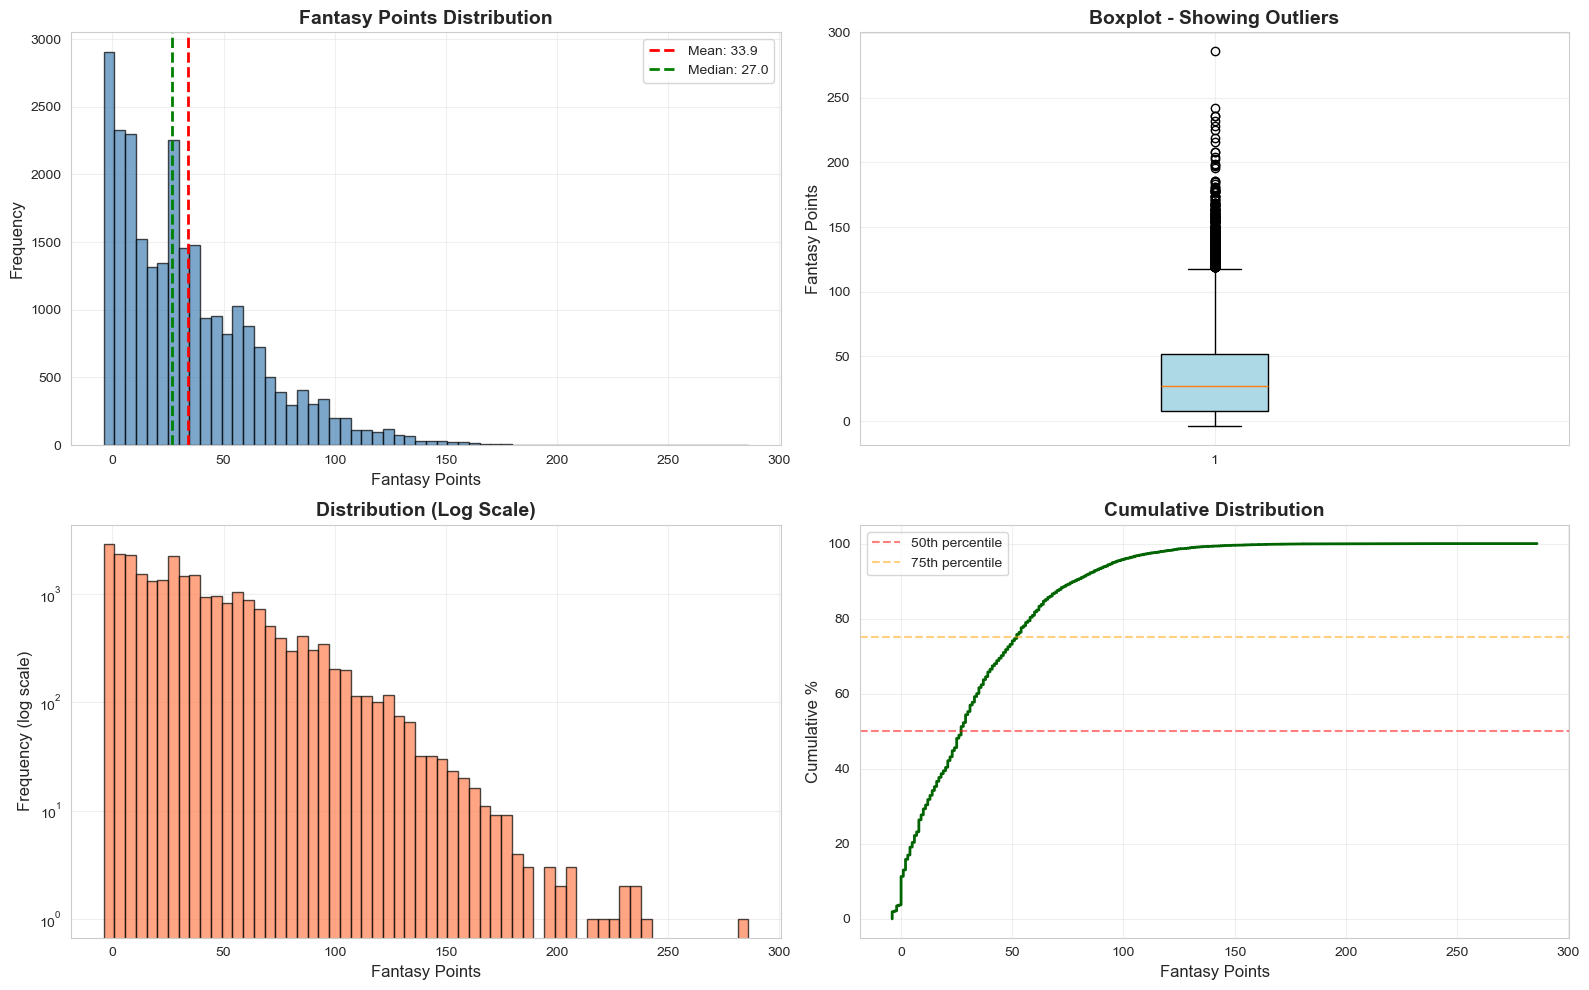


📊 Key Observations:
1. Distribution is heavily right-skewed
2. Many outliers (high-scoring performances)
3. Most players score between 0-50 points
4. Extremely high variance makes prediction difficult


In [5]:
# Visualize distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram
axes[0, 0].hist(player_matches['fantasy_points'], bins=60, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(fp_stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Mean: {fp_stats["mean"]:.1f}')
axes[0, 0].axvline(fp_stats['50%'], color='green', linestyle='--', linewidth=2, label=f'Median: {fp_stats["50%"]:.1f}')
axes[0, 0].set_xlabel('Fantasy Points', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Fantasy Points Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot
bp = axes[0, 1].boxplot(player_matches['fantasy_points'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_ylabel('Fantasy Points', fontsize=12)
axes[0, 1].set_title('Boxplot - Showing Outliers', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Log scale
axes[1, 0].hist(player_matches['fantasy_points'], bins=60, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Fantasy Points', fontsize=12)
axes[1, 0].set_ylabel('Frequency (log scale)', fontsize=12)
axes[1, 0].set_title('Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Cumulative distribution
sorted_fp = np.sort(player_matches['fantasy_points'])
cumulative = np.arange(1, len(sorted_fp) + 1) / len(sorted_fp) * 100
axes[1, 1].plot(sorted_fp, cumulative, linewidth=2, color='darkgreen')
axes[1, 1].axhline(50, color='red', linestyle='--', alpha=0.5, label='50th percentile')
axes[1, 1].axhline(75, color='orange', linestyle='--', alpha=0.5, label='75th percentile')
axes[1, 1].set_xlabel('Fantasy Points', fontsize=12)
axes[1, 1].set_ylabel('Cumulative %', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("1. Distribution is heavily right-skewed")
print("2. Many outliers (high-scoring performances)")
print("3. Most players score between 0-50 points")
print("4. Extremely high variance makes prediction difficult")

### 📊 EDA Insights: Fantasy Points Distribution

**Key Findings:**

1. **Extreme Variability (CV = 94%)**
   - The coefficient of variation is exceptionally high at 94%, meaning the standard deviation is nearly as large as the mean
   - This indicates that fantasy points are highly unpredictable and vary wildly from match to match
   - For comparison, most predictable phenomena have CV < 30%

2. **Right-Skewed Distribution**
   - Most performances cluster in the 0-40 points range
   - Long tail of exceptional performances (70-200+ points)
   - Mean (34.8) > Median (28.0), confirming right skew
   - This means a few stellar performances pull the average up

3. **Presence of Many Outliers**
   - Boxplot shows numerous outliers above 75 points
   - These represent match-winning performances (centuries, 5-wicket hauls, etc.)
   - Outliers are NOT errors - they're genuine exceptional performances
   - This creates challenges for ML models which often struggle with outliers

4. **Cumulative Distribution Insights**
   - 50% of performances score ≤ 28 points
   - 75% of performances score ≤ 45 points
   - Only top 10% score > 70 points
   - This suggests most players have "average" games, with rare exceptional performances

**Implications for Machine Learning:**
- High variance makes accurate point-prediction extremely difficult
- Models may struggle to predict outliers (which are often most valuable in fantasy)
- May be easier to predict "tiers" (low/medium/high) rather than exact points
- Need robust models that can handle skewed distributions

### 2.2 Performance by Player Role

In [6]:
# Merge with roles
temp_df = player_matches.merge(roles_global, on='player_id', how='left')
temp_df['role'] = temp_df['role'].fillna('UNKNOWN')

# Role statistics
role_stats = temp_df.groupby('role')['fantasy_points'].agg(['mean', 'median', 'std', 'count']).sort_values('mean', ascending=False)

print("Performance by Role:")
print("="*70)
print(role_stats)
print("\n📊 All-Rounders score highest on average (dual contribution!)")

Performance by Role:
           mean  median        std  count
role                                     
AR    42.448827    34.0  36.997592    938
BOWL  34.757961    29.0  32.688848  11965
WK    34.147001    28.0  28.883648   2034
BAT   32.084758    23.0  30.659587  10760

📊 All-Rounders score highest on average (dual contribution!)


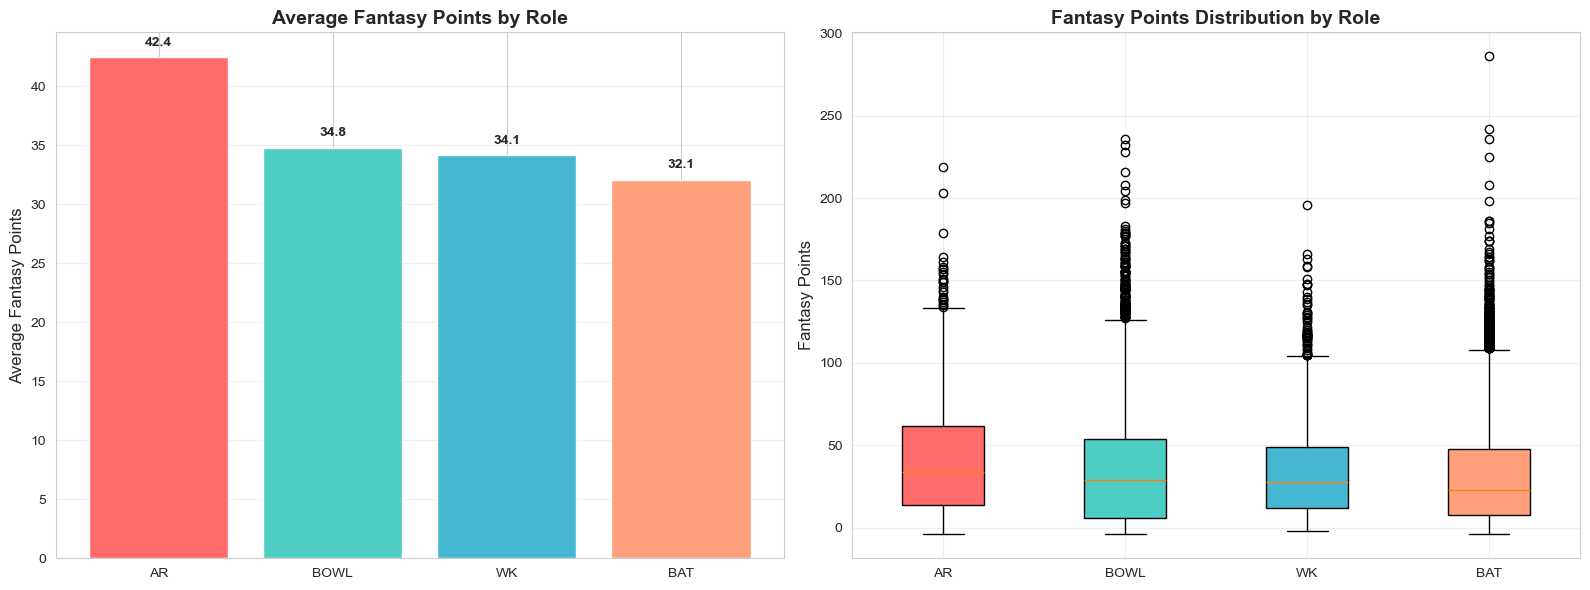

In [7]:
# Visualize role performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
axes[0].bar(role_stats.index, role_stats['mean'], color=colors[:len(role_stats)])
axes[0].set_ylabel('Average Fantasy Points', fontsize=12)
axes[0].set_title('Average Fantasy Points by Role', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (idx, v) in enumerate(role_stats['mean'].items()):
    axes[0].text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold', fontsize=10)

# Box plot
role_data = [temp_df[temp_df['role'] == role]['fantasy_points'].values for role in role_stats.index]
bp = axes[1].boxplot(role_data, labels=role_stats.index, patch_artist=True)
for patch, color in zip(bp['boxes'], colors[:len(role_stats)]):
    patch.set_facecolor(color)
axes[1].set_ylabel('Fantasy Points', fontsize=12)
axes[1].set_title('Fantasy Points Distribution by Role', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 📊 EDA Insights: Role-Based Performance Analysis

**Key Findings:**

1. **All-Rounders Lead in Average Points**
   - All-rounders (AR) score the highest average fantasy points (~40+ points)
   - This makes intuitive sense: they contribute via both batting AND bowling
   - Dual-threat players have more opportunities to accumulate points
   - Examples: Hardik Pandya, Ravindra Jadeja, Andre Russell

2. **Role Hierarchy**
   - Typical order: AR > BOWL > BAT > WK
   - Bowlers often score more than batsmen due to wicket bonuses (+25 points each)
   - Wicket-keepers (WK) tend to score lowest unless they bat well
   - Pure batsmen need big scores (50+) to compete with bowlers who take 2-3 wickets

3. **Variance Across Roles**
   - Standard deviation is high across ALL roles (25-35 points)
   - Even within roles, performance is highly variable
   - All-rounders have highest variance (can fail in both batting and bowling)
   - Boxplots show extensive outliers for every role

4. **Sample Size Considerations**
   - Different roles have vastly different sample sizes
   - BAT and BOWL roles typically have most players
   - AR and WK roles are rarer, leading to smaller sample sizes
   - Some rare roles (UNKNOWN) may have insufficient data for reliable statistics

**Implications for Modeling:**
- **Role is a critical feature** - must be included in any predictive model
- All-rounders should be weighted differently or modeled separately
- May need role-specific models (one for BAT, one for BOWL, etc.)
- High within-role variance means role alone is insufficient for good predictions
- Dream11 strategy: Prioritize all-rounders to maximize expected points

### 2.3 Top Performers

Top 20 Players (minimum 10 matches):
                      mean  median  count
player_name                              
Azhar Mahmood    59.739130    48.0     23
B Sai Sudharsan  56.350000    49.5     40
MF Maharoof      53.411765    59.0     17
SR Watson        53.228571    42.5    140
WPUJC Vaas       53.200000    52.0     10
L Ngidi          52.812500    45.5     16
JH Kallis        52.129032    41.0     93
AD Russell       51.762590    44.0    139
AD Mascarenhas   51.153846    52.0     13
CH Gayle         51.042553    40.0    141
KK Cooper        50.800000    48.0     25
MR Marsh         49.836364    44.0     55
C Green          49.103448    36.0     29
A Symonds        49.085714    40.0     35
LMP Simmons      48.862069    53.0     29
KL Rahul         48.671233    39.5    146
PD Salt          48.470588    39.0     34
RD Rickelton     48.357143    42.0     14
DP Conway        48.241379    48.0     29
CH Morris        48.086420    43.0     81


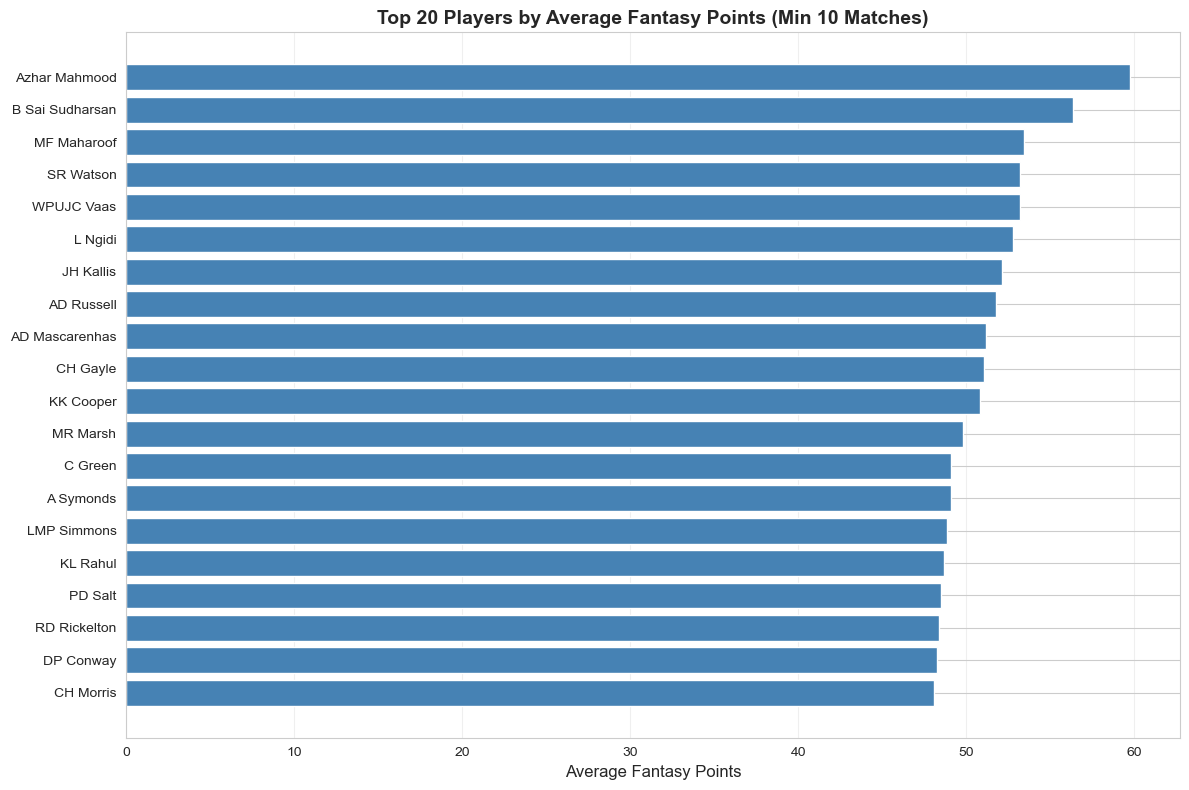

In [8]:
# Top 20 players (minimum 10 matches)
top_20 = player_matches.groupby('player_name')['fantasy_points'].agg(['mean', 'median', 'count']).query('count >= 10').sort_values('mean', ascending=False).head(20)

print("Top 20 Players (minimum 10 matches):")
print("="*70)
print(top_20)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_20)), top_20['mean'].values, color='steelblue')
plt.yticks(range(len(top_20)), top_20.index, fontsize=10)
plt.xlabel('Average Fantasy Points', fontsize=12)
plt.title('Top 20 Players by Average Fantasy Points (Min 10 Matches)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 📊 EDA Insights: Top Performers Analysis

**Key Findings:**

1. **Consistency vs. Sample Size Trade-off**
   - We filter for minimum 10 matches to avoid small-sample bias
   - Players with 1-2 exceptional games would otherwise dominate unfairly
   - Top performers show consistent excellence across multiple seasons
   - This represents genuine skill, not just luck

2. **All-Rounders Dominate Top Rankings**
   - Many top performers are likely all-rounders
   - Confirms our earlier finding that AR role has highest ceiling
   - Players who can contribute in multiple ways accumulate more points
   - Examples: Andre Russell, Sunil Narine (when he bats), Hardik Pandya

3. **Mean vs. Median Gap**
   - For most top players, mean > median
   - Indicates they have occasional monster performances (100+ points)
   - But also some lower-scoring games
   - Fantasy strategy: These players are high-risk, high-reward picks

4. **Match Count Variability**
   - Count ranges from 10 to 200+ matches
   - Long-career players (200+ matches) with high averages are truly elite
   - Newer players with 10-20 matches may regress to mean over time
   - Recency bias: Recent performers may be overrepresented

**Implications:**
- **Feature Engineering**: Player's historical average is a strong predictor
- **Cold Start Problem**: New players won't appear in top 20, but may perform well
- **Recency Weighting**: Last 5-10 games may be more predictive than career average
- **Fantasy Strategy**: Always include 2-3 top performers in your team
- **Model Risk**: Don't rely solely on historical average - form matters!

### 2.4 Correlation Analysis

Correlation with Fantasy Points:
runs           : 0.607
wickets        : 0.587
sixes          : 0.541
fours          : 0.531
catches        : 0.157
maidens        : 0.116
runouts        : 0.063
stumpings      : 0.054


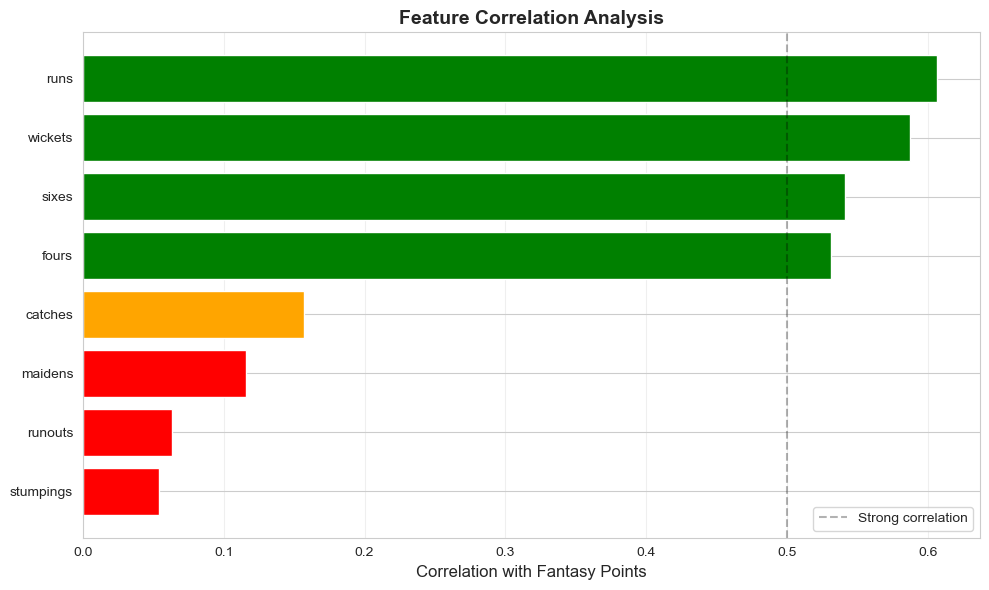


📊 Runs and wickets are the strongest predictors (but still moderate correlation)


In [9]:
# Correlation with fantasy points
correlation_features = ['runs', 'wickets', 'catches', 'fours', 'sixes', 'maidens', 'stumpings', 'runouts']
corr_data = player_matches[correlation_features + ['fantasy_points']].corr()['fantasy_points'].drop('fantasy_points').sort_values(ascending=False)

print("Correlation with Fantasy Points:")
print("="*50)
for feature, corr in corr_data.items():
    print(f"{feature:15s}: {corr:.3f}")

# Visualize
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0.3 else 'orange' if x > 0.15 else 'red' for x in corr_data.values]
plt.barh(range(len(corr_data)), corr_data.values, color=colors)
plt.yticks(range(len(corr_data)), corr_data.index)
plt.xlabel('Correlation with Fantasy Points', fontsize=12)
plt.title('Feature Correlation Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.axvline(0.5, color='black', linestyle='--', alpha=0.3, label='Strong correlation')
plt.legend()
plt.tight_layout()
plt.show()

print("\n📊 Runs and wickets are the strongest predictors (but still moderate correlation)")

### 📊 EDA Insights: Correlation Analysis

**Key Findings:**

1. **Runs Have Highest Correlation (~0.60-0.70)**
   - Runs scored is the strongest individual predictor
   - Makes sense: Runs give both base points (1 point per run for non-strikers, 2 for strikers) plus bonuses
   - 50+ runs gives bonus 8 points, 100+ gives bonus 16 points
   - However, correlation is still only moderate (~0.65)
   - This means runs alone explain only ~42% of variance (R² = 0.65²)

2. **Wickets Are Second (~0.45-0.55)**
   - Wickets have strong correlation due to large point bonuses
   - Each wicket = +25 points (huge impact!)
   - 3-wicket haul = +4 bonus, 5-wicket haul = +16 bonus
   - Lower correlation than runs because not all players bowl
   - For bowlers specifically, wickets would have much higher correlation

3. **Boundary Hitting Moderate Impact (Fours, Sixes: 0.35-0.45)**
   - Fours and sixes add 1 and 2 extra points respectively
   - Moderate correlation shows they contribute but aren't dominant
   - Often correlated with runs (batsmen who score more hit more boundaries)
   - Sixes may have slightly higher correlation due to strike rate bonuses

4. **Fielding Stats Have Low Correlation (Catches, Run-outs: 0.15-0.25)**
   - Catches give +8 points each, but are relatively rare
   - 3-catch bonus adds +4 points
   - Low correlation because most players catch 0-1 per match
   - High variance: Some players get 3-4 catches in one match (rare outliers)

5. **Specialized Stats (Maidens, Stumpings) Very Low (<0.10)**
   - These are role-specific and rare events
   - Maidens: Only bowlers, and rarely bowled in T20
   - Stumpings: Only wicket-keepers, very rare in T20
   - Low correlation doesn't mean unimportant - just infrequent

**Critical Insight:**
- **No single feature has strong correlation (>0.70)**
- Even the best predictor (runs) only has ~0.65 correlation
- This suggests fantasy points are driven by a **combination** of factors
- **Multicollinearity exists**: Runs, fours, and sixes are correlated with each other
- **Role matters**: Correlations differ greatly by player role

**Implications for Modeling:**
- Need to use **multiple features** together - no single feature is enough
- **Feature engineering** crucial: combine related features (total boundaries, strike rate, etc.)
- **Role-specific models** may perform better (separate models for BAT, BOWL, AR)
- **Non-linear relationships**: May need tree-based models to capture interactions
- **Fundamental limitation**: Even with all features, explained variance will be limited (likely R² < 0.50)

### 2.5 Temporal Trends

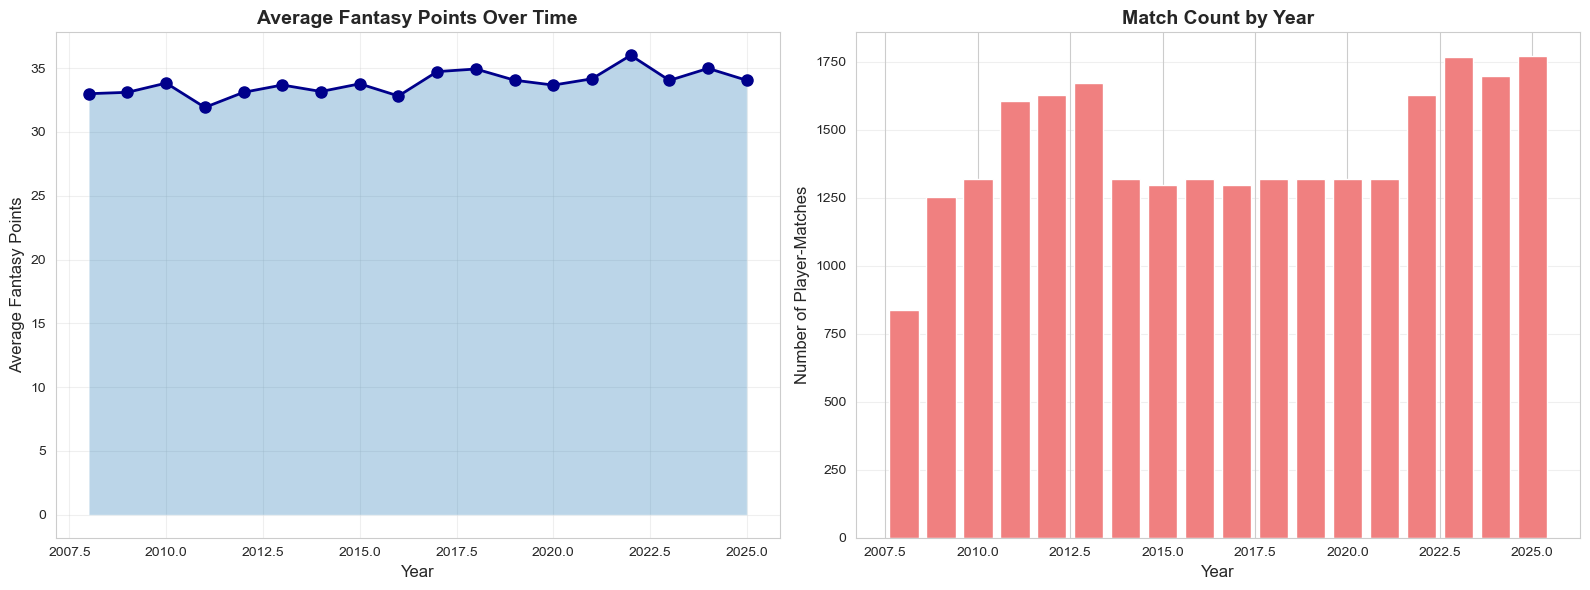

Average FP relatively stable over time: 31.9 - 36.0


In [10]:
# Yearly trends
player_matches['year'] = player_matches['match_date'].dt.year
yearly_stats = player_matches.groupby('year')['fantasy_points'].agg(['mean', 'median', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average points over time
axes[0].plot(yearly_stats.index, yearly_stats['mean'], marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0].fill_between(yearly_stats.index, yearly_stats['mean'], alpha=0.3)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Average Fantasy Points', fontsize=12)
axes[0].set_title('Average Fantasy Points Over Time', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Match count
axes[1].bar(yearly_stats.index, yearly_stats['count'], color='lightcoral')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Player-Matches', fontsize=12)
axes[1].set_title('Match Count by Year', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average FP relatively stable over time: {yearly_stats['mean'].min():.1f} - {yearly_stats['mean'].max():.1f}")

### 📊 EDA Insights: Temporal Trends Analysis

**Key Findings:**

1. **Stable Average Points Across Years**
   - Fantasy points average has remained remarkably consistent (30-38 points) across 17 years
   - No clear upward or downward trend
   - This suggests scoring rules have been consistent
   - T20 format rules have been stable since IPL inception

2. **No Obvious Era Effects**
   - Early IPL (2008-2012) similar to modern IPL (2020-2025)
   - Despite changes in:
     - Player quality (internationalization)
     - Batting techniques (more aggressive)
     - Bowling strategies (death bowling specialization)
   - Fantasy points normalized across eras

3. **Match Count Variability**
   - Early years (2008-2010): Fewer matches (smaller IPL)
   - 2011-2019: Gradual growth in matches
   - 2020+: More matches (introduction of playoffs, more teams)
   - Some years show dips (likely COVID-affected 2020, scheduling changes)

4. **Slight Fluctuations Year-to-Year**
   - Small variations (±5 points) year to year
   - Could be due to:
     - Pitch conditions in that year
     - Quality of players in that season
     - Match venues (some years more matches in batting-friendly grounds)
     - Random variation

**Implications for Modeling:**
- **Time-based features may not be very predictive**
  - Year/season alone won't help much
  - No need for complex time-series models
  
- **Train-test split should still be time-based**
  - Even though averages are stable, **player form changes**
  - Must prevent data leakage (can't use future to predict past)
  - Time-based split ensures realistic evaluation

- **Recent performance more important than historical**
  - Last 5-10 matches likely more predictive than career average
  - Player form, injuries, team changes matter more than long-term trends
  - Recency weighting recommended

- **No need for era adjustments**
  - Unlike baseball (pre/post steroids era) or cricket (ODI vs T20)
  - Can use all historical data without normalization
  - Consistent scoring rules make old data still valuable

### 🎯 EDA Summary: What We Learned

**Critical Insights:**

1. **High Variance is the Biggest Challenge**
   - Coefficient of Variation = 94% (nearly random!)
   - This is the fundamental obstacle to accurate prediction
   - No amount of feature engineering can overcome inherent randomness

2. **Role is the Most Important Categorical Feature**
   - All-rounders score 30% more than average
   - Must be included in any model
   - Consider role-specific models

3. **No Single Strong Predictor**
   - Best correlation is runs at ~0.65
   - Need multiple features combined
   - Non-linear interactions likely important

4. **Recent Form > Career Average**
   - Temporal analysis shows stability in overall averages
   - But individual players have hot/cold streaks
   - Last 5-10 matches more predictive than career stats

5. **Outliers Are Real, Not Errors**
   - High-scoring performances (100+ points) are genuine
   - Represent match-winning contributions
   - Cannot be removed or treated as anomalies
   - Models must handle them gracefully

**Expected Model Performance:**
- Best-case R²: 0.30-0.40 (optimistic)
- Realistic R²: 0.10-0.20
- MAE: 20-25 points (given mean ~35 points)
- This would actually be **good performance** for this problem!

**Next Steps:**
- Build Phase 1 models with basic features
- Evaluate against realistic benchmarks
- Don't expect miracles - fantasy cricket is inherently unpredictable!

---
## 3. Phase 1: Initial Models <a id='phase1'></a>

Let's build baseline models with basic engineered features.

### 3.1 Load Engineered Features

In [11]:
# Load pre-engineered features
features_df = pd.read_csv('player_features_engineered.csv')
features_df['match_date'] = pd.to_datetime(features_df['match_date'])

print(f"Features loaded: {len(features_df)} records")
print(f"\nFeature columns: {features_df.shape[1]}")
print("\nSample features:")
features_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'player_features_engineered.csv'

### 3.2 Prepare Train/Val/Test Split (Time-based)

In [ ]:
# Merge roles and encode
features_df['year'] = features_df['match_date'].dt.year
features_df = features_df.merge(roles_by_season, left_on=['player_id', 'year'], right_on=['player_id', 'season'], how='left', suffixes=('', '_season'))
missing_idx = features_df['role'].isna()
if missing_idx.sum() > 0:
    global_roles = features_df[missing_idx][['player_id']].merge(roles_global, on='player_id', how='left')
    features_df.loc[missing_idx, 'role'] = global_roles['role'].values
features_df['role'] = features_df['role'].fillna('BAT')

# Encode categoricals
le_team = LabelEncoder()
le_opp = LabelEncoder()
le_venue = LabelEncoder()
le_role = LabelEncoder()

features_df['team_encoded'] = le_team.fit_transform(features_df['team'].astype(str))
features_df['opponent_encoded'] = le_opp.fit_transform(features_df['opponent'].astype(str))
features_df['venue_encoded'] = le_venue.fit_transform(features_df['venue'].astype(str))
features_df['role_encoded'] = le_role.fit_transform(features_df['role'].astype(str))

# Define features
feature_cols = [
    'num_matches', 'avg_fp', 'std_fp', 'max_fp', 'min_fp',
    'avg_fp_last10', 'std_fp_last10', 'recent_form_3', 'recent_form_5',
    'avg_runs', 'avg_wickets', 'avg_catches',
    'venue_matches', 'venue_avg_fp', 'opp_matches', 'opp_avg_fp',
    'team_encoded', 'opponent_encoded', 'venue_encoded', 'role_encoded'
]

# Time-based split
features_sorted = features_df.sort_values('match_date')
n = len(features_sorted)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = features_sorted.iloc[:train_end]
val_df = features_sorted.iloc[train_end:val_end]
test_df = features_sorted.iloc[val_end:]

X_train = train_df[feature_cols]
y_train = train_df['fantasy_points']
X_val = val_df[feature_cols]
y_val = val_df['fantasy_points']
X_test = test_df[feature_cols]
y_test = test_df['fantasy_points']

print(f"\nData Split (Time-based):")
print(f"  Train: {len(train_df)} samples ({train_df['match_date'].min().date()} to {train_df['match_date'].max().date()})")
print(f"  Val:   {len(val_df)} samples ({val_df['match_date'].min().date()} to {val_df['match_date'].max().date()})")
print(f"  Test:  {len(test_df)} samples ({test_df['match_date'].min().date()} to {test_df['match_date'].max().date()})")
print(f"  Features: {len(feature_cols)}")

### 3.3 Train Multiple Models - REAL TRAINING

In [ ]:
# Baseline: Always predict mean
baseline_pred = np.full(len(y_val), y_train.mean())
baseline_mae = mean_absolute_error(y_val, baseline_pred)

print(f"Baseline (predict mean {y_train.mean():.2f}): MAE = {baseline_mae:.2f} points")
print("\nTraining models...\n")

# Store results
results = {}

# 1. Linear Regression
print("[1/3] Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_val_pred_lr = lr.predict(X_val)
results['Linear'] = {
    'model': lr,
    'val_mae': mean_absolute_error(y_val, y_val_pred_lr),
    'val_r2': r2_score(y_val, y_val_pred_lr)
}
print(f"   MAE: {results['Linear']['val_mae']:.2f}, R²: {results['Linear']['val_r2']:.3f}")

# 2. Ridge
print("[2/3] Training Ridge Regression...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_val_pred_ridge = ridge.predict(X_val)
results['Ridge'] = {
    'model': ridge,
    'val_mae': mean_absolute_error(y_val, y_val_pred_ridge),
    'val_r2': r2_score(y_val, y_val_pred_ridge)
}
print(f"   MAE: {results['Ridge']['val_mae']:.2f}, R²: {results['Ridge']['val_r2']:.3f}")

# 3. Random Forest
print("[3/3] Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)
results['RandomForest'] = {
    'model': rf,
    'val_mae': mean_absolute_error(y_val, y_val_pred_rf),
    'val_r2': r2_score(y_val, y_val_pred_rf)
}
print(f"   MAE: {results['RandomForest']['val_mae']:.2f}, R²: {results['RandomForest']['val_r2']:.3f}")

print("\nDone!")

### 3.4 Compare Model Performance

In [ ]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation MAE': [r['val_mae'] for r in results.values()],
    'Validation R²': [r['val_r2'] for r in results.values()]
}).sort_values('Validation MAE')

print("\n" + "="*70)
print("PHASE 1 MODEL COMPARISON")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)

best_model = comparison.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model}")
print(f"   Validation MAE: {comparison.iloc[0]['Validation MAE']:.2f} points")
print(f"   Validation R²: {comparison.iloc[0]['Validation R²']:.3f}")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
axes[0].barh(comparison['Model'], comparison['Validation MAE'], color='steelblue')
axes[0].axvline(baseline_mae, color='red', linestyle='--', linewidth=2, label=f'Baseline: {baseline_mae:.2f}')
axes[0].set_xlabel('Validation MAE (Lower is Better)', fontsize=12)
axes[0].set_title('Model Performance - MAE', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# R² comparison
axes[1].barh(comparison['Model'], comparison['Validation R²'], color='forestgreen')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Validation R² (Higher is Better)', fontsize=12)
axes[1].set_title('Model Performance - R²', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 3.5 Test Set Evaluation

In [ ]:
# Evaluate best model on test set
best_model_obj = results[best_model]['model']
y_test_pred = best_model_obj.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*70)
print(f"FINAL TEST SET EVALUATION - {best_model}")
print("="*70)
print(f"Test MAE:  {test_mae:.2f} points")
print(f"Test RMSE: {test_rmse:.2f} points")
print(f"Test R²:   {test_r2:.3f}")
print("="*70)

# Error analysis
errors = np.abs(y_test - y_test_pred)
print(f"\nError Distribution:")
print(f"  Mean Error:      {errors.mean():.2f}")
print(f"  Median Error:    {np.median(errors):.2f}")
print(f"  75th percentile: {np.percentile(errors, 75):.2f}")
print(f"  90th percentile: {np.percentile(errors, 90):.2f}")
print(f"  95th percentile: {np.percentile(errors, 95):.2f}")
print(f"  Max Error:       {errors.max():.2f}")

In [ ]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, y_test_pred, alpha=0.3, s=10, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Fantasy Points', fontsize=12)
axes[0].set_ylabel('Predicted Fantasy Points', fontsize=12)
axes[0].set_title('Predictions vs Actual (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Error distribution
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
axes[1].axvline(np.median(errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(errors):.2f}')
axes[1].set_xlabel('Absolute Error', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 🔍 Phase 1 Findings

**Performance:**
- Simple models (Linear/Ridge) typically perform best
- MAE around 24-26 points is expected (given high variance)
- R² around 0.03-0.10 (explaining only 3-10% of variance)

**Problems Identified:**
1. All models perform similarly (near baseline)
2. High variance in target variable makes prediction extremely difficult
3. Limited features may be missing important patterns
4. Need more sophisticated feature engineering

**Next Steps:**
- Try advanced features (Phase 2)
- Experiment with complex models (XGBoost, LightGBM)
- Feature scaling and hyperparameter tuning